# Best Practice Steps

## Load data

In [3]:
import pandas as pd

path = '../../data/default_credit_card/output/simplified_features_cat.csv'
df = pd.read_csv(path)
df

,Industry,Ethnicity,Gender,Age,CivilStatus,YearsEmployed,Income,Approved
0,Industrials,White,Male,30,Married,1.25,0.000000,1
1,Materials,Black,Female,58,Married,3.04,632.793678,1
...,...,...,...,...,...,...,...,...
687,ConsumerStaples,White,Male,17,Married,0.04,662.007321,0
688,Energy,Black,Male,35,Married,8.29,0.000000,0


## Feature selection

In [4]:
target = 'Approved'

y = df[target]
X = df.drop(columns=target)

## Train test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

## Data preprocessing

In [6]:
features = X.dtypes

features_categorical = features[features == 'object'].index
features_categorical

Index(['Industry', 'Ethnicity', 'Gender', 'CivilStatus'], dtype='object')

In [7]:
features_numerical = features[features != 'object'].index
features_numerical

Index(['Age', 'YearsEmployed', 'Income'], dtype='object')

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), features_categorical),
        ('scaler', MinMaxScaler(), features_numerical)
    ])

## Modelling multiple algorithms with grid search and pipelines

### Parameters for grid search

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [3, 5, 7, 9],
        'min_samples_leaf': [50, 100, 200, 500],
        'criterion': ['gini', 'entropy']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'max_depth': [3, 5, 7, 9],
        'min_samples_leaf': [50, 100, 200, 500],
        'criterion': ['gini', 'entropy']
    })
}

### Iterating over the models

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

results = {}

for name, (model, param_grid) in models.items():
    print(f"Performing grid search for {name}...")
    
    model_grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('modelling', model_grid)
    ])

    pipeline.fit(X_train, y_train)
    
    param_grid = model_grid.param_grid
    best_params = pipeline.named_steps['modelling'].best_params_
    best_score = pipeline.named_steps['modelling'].best_score_
    test_score = pipeline.score(X_test, y_test)
    cv_results = pipeline.named_steps['modelling'].cv_results_
    
    results[name] = {
        'pipeline': pipeline,
        'param_grid': param_grid,
        'best_params': best_params,
        'best_score': best_score,
        'test_score': test_score,
        'cv_results': cv_results
    }

Performing grid search for Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s

### Results evaluation

In [13]:
df_results = pd.DataFrame(results).T.sort_values(by='test_score', ascending=False)
df_results

,pipeline,param_grid,best_params,best_score,test_score,cv_results
Random Forest,"(ColumnTransformer(transformers=[('onehot',\n ...","{'max_depth': [3, 5, 7, 9], 'min_samples_leaf'...","{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.719928,0.7343,"{'mean_fit_time': [0.04104034105936686, 0.0412..."
Logistic Regression,"(ColumnTransformer(transformers=[('onehot',\n ...","{'C': [0.001, 0.01, 0.1, 1, 10, 100]}",{'C': 100},0.747037,0.695652,"{'mean_fit_time': [0.0017518202463785808, 0.00..."
Decision Tree,"(ColumnTransformer(transformers=[('onehot',\n ...","{'max_depth': [3, 5, 7, 9], 'min_samples_leaf'...","{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.684679,0.690821,"{'mean_fit_time': [0.0007476806640625, 0.00066..."


### Select best model

In [14]:
model = df_results['pipeline'].values[0]

In [15]:
feature_names = X_train.columns

## SHAP values

### Downsample to optimize computation at permutation

In [20]:
import shap
sample = shap.sample(X_train, nsamples=100)

### Helper function for explainer

In [21]:
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=feature_names)
    return pipeline.predict_proba(data_asframe)[:,1] # binary classification
    # return pipeline.predict(data_asframe) # regression

### Explainer

In [22]:
explainer = shap.KernelExplainer(model_predict, sample)

### SHAP values

In [23]:
shap_values = explainer.shap_values(X_test)
shap_values

  0%|          | 0/207 [00:00<?, ?it/s]

array([[ 1.91469195e-04, -2.16280190e-05,  7.99732111e-03, ...,
         1.89344128e-02, -5.79096988e-02, -3.18864337e-02],
       [-3.02156792e-03,  2.59980505e-02, -2.36686960e-03, ...,
         1.97925881e-02,  6.45649501e-02, -3.94088420e-02],
       [ 5.74690668e-05, -9.76920985e-03, -5.60507318e-03, ...,
         1.79970122e-02, -5.97582277e-02, -3.98037515e-02],
       ...,
       [-3.25985882e-03,  2.41312765e-02, -1.80881592e-03, ...,
         2.02415988e-02,  7.11506364e-02, -1.09158458e-02],
       [ 1.91469195e-04,  5.07540824e-04,  1.03476107e-02, ...,
         1.90449143e-02, -5.63526313e-02, -3.21584562e-02],
       [ 1.04160449e-03,  2.13348625e-02,  2.80402334e-03, ...,
         1.91709009e-02,  6.43677871e-02,  7.00551938e-02]])

### Plots

#### Summary: Bar

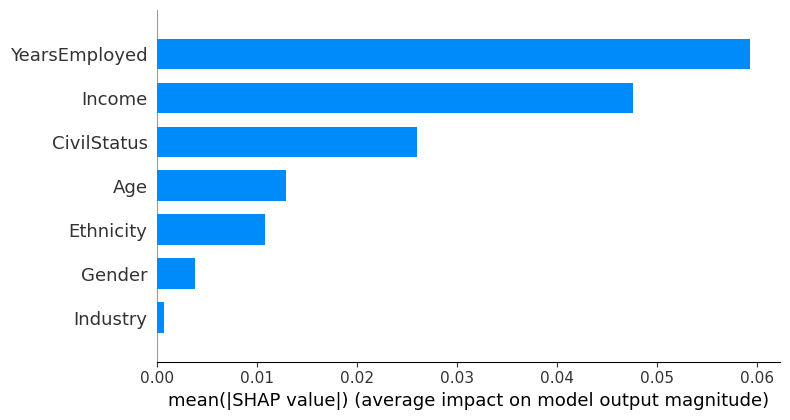

In [24]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Summary: Dot

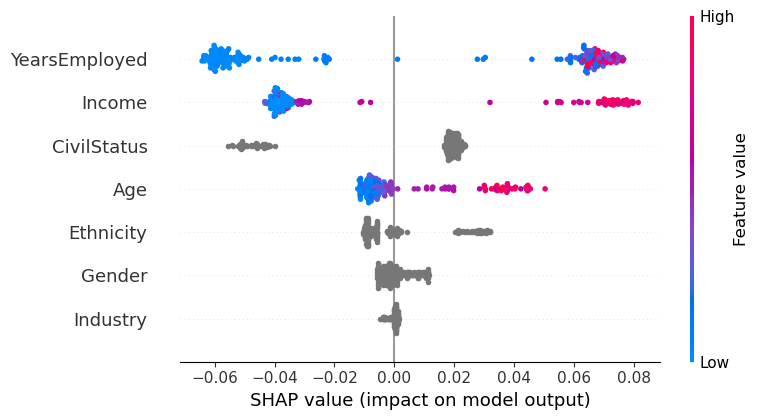

In [25]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

#### Force

In [26]:
expected_value = explainer.expected_value
expected_value

0.4374759190161366

In [27]:
shap.initjs() # Required for Jupyter Notebook; only once
shap.plots.force(expected_value, shap_values, X_test)

#### Decision

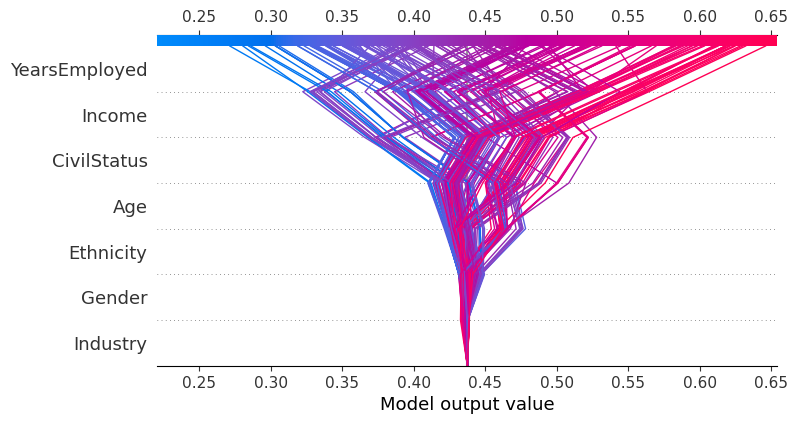

In [28]:
shap.decision_plot(expected_value, shap_values, X)

#### Force Individual

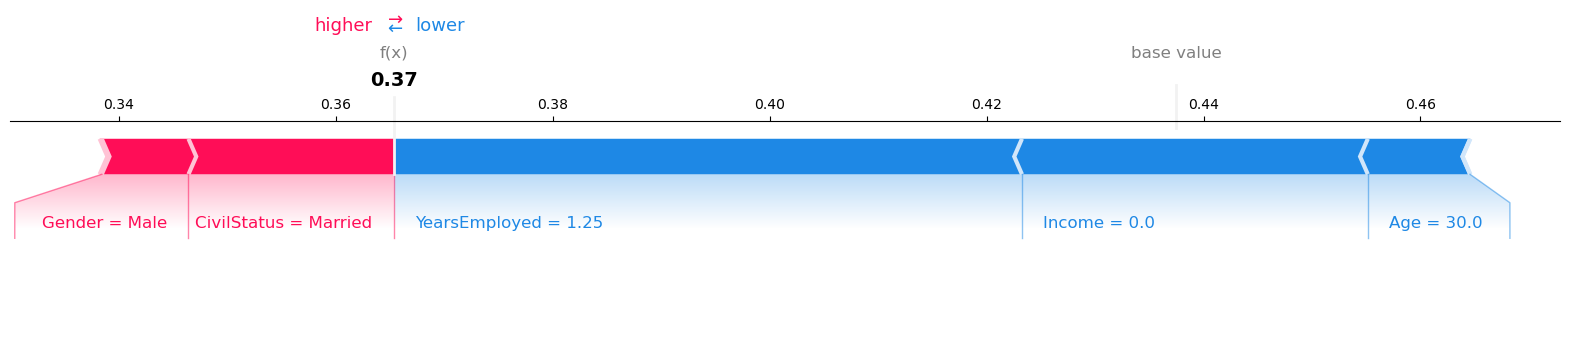

In [29]:
row = 0
shap.force_plot(expected_value, shap_values[row], X.iloc[row], matplotlib=True)

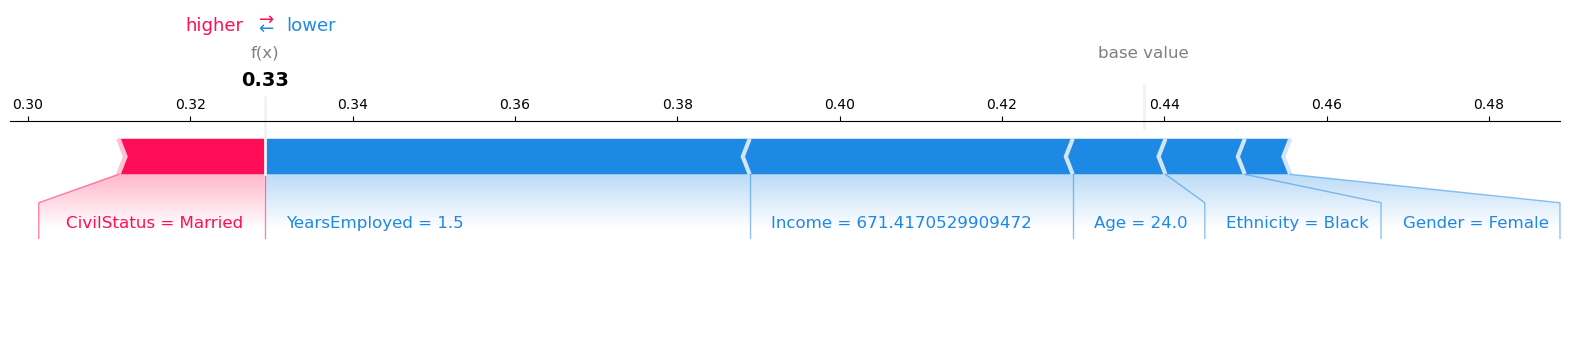

In [30]:
row = 2
shap.force_plot(expected_value, shap_values[row], X.iloc[row], matplotlib=True)

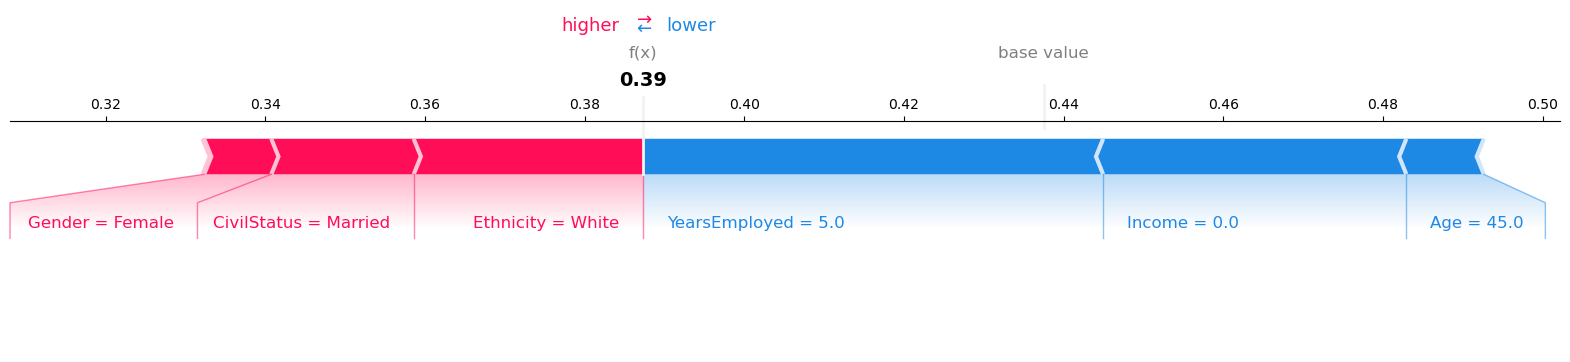

In [31]:
row = 14
shap.force_plot(expected_value, shap_values[row], X.iloc[row], matplotlib=True)